In [1]:
import numpy as np
from scipy.integrate import odeint
# import matplotlib.pyplot as plt
from matplotlib import pyplot as PLT
import math
import pandas as pd
import seaborn as sns; sns.set()

In [2]:
def RSteadyState(N,I):
    return -1*((1 + np.exp(p*I))*(alpha + g*N))/ (c + c*np.exp(p*I-delta_R))
def NSteadyState(R):
    return (1+np.exp(z*R)*(beta)) / (g + delta_N + g*np.exp(z*R) + delta_N*np.exp(z*R) + mu)
def TSteadyState(N,I,R):
    return (-mu*N)/(a*I + delta_T + a*I*np.exp(z*R) - delta_T*np.exp(z*R))
def ISteadyState(T,R):
    return (s*T)/(e_T*T + e_R*R + delta_I)
    

In [3]:
#function that returns dy/dt
def model(ic,t,co):
    # Initial conditions
    N = ic[0] #N = naive T-cells
    T = ic[1] #T = Activated T-cells
    I = ic[2] #I = IL-2
    R = ic[3] #R = TRegs
    
    # Constant Values
    beta = co[0]
    mu =co[1]
    delta_N = co[2]   
    a = co[3]
    delta_T = co[4]
    s = co[5]
    e_T = co[6]
    delta_I = co[7]
    alpha = co[8]
    c = co[9]
    g = co[10]
    e_R = co[11]
    p = co[12]
    z = co[13]
    delta_R = co[14]
    Thy = co[15]
    Thy_max = co[16]

    
    dRdt = alpha*(Thy/Thy_max) + g*N + c*R - delta_R*R*(1/(1+np.exp(p*I)))
    dNdt = beta*(Thy/Thy_max) - mu*N*(1/(1+np.exp(z*R))) - g*N - delta_N*N 
    dTdt = mu*N*(1/(1+np.exp(z*R))) + a*I*T - delta_T*T
    dIdt = s*T - e_T*I*T - e_R*I*R - delta_I*I
    
    
    return [dNdt, dTdt, dIdt, dRdt]

In [4]:
############################
#  Thymus and limitations  #
############################
alpha = 1 #------------ T Regulatory Cells
beta = 60   #---------- Naive T cells
Thy = 1 #------------ Size of the thymus
Thy_max = 1 #------- Max size of the thymus


#########################################
#  Naive T cell Differentiation Rates   #
#########################################
g = 0.01 #--------To T regulatory Cells
mu = 25 #------ To activated T cells

##############################################
#  IL-2 Cytokine Expression and Consumption  #
##############################################
s = 0.02 #.7 #------- T Cell Expression
e_T = 0.01 #------ T Cell Consumption Rate
e_R = 0.01 #------ T Reg Consumption Rate

###########
#  Tregs  #
###########
p = 2 #----- Strenght of effect on Treg death Rate
c = 0.01 #------------T regulatory cell Self replication
z = 0.55 #------- Strength of suppression on Naive T cell differention to activation

######################################################
#  IL-2 Cytokine Effects and Self Replication Rates  #
######################################################
a = 0.02   #------------Activated T cells


##################
#  Death Rates   #
##################
delta_N = 0.01 #-----------Naive T cells
delta_T = 0.01 #-----------Activated T cells
delta_R = 2 #----------Regulatory T Cells
delta_I = 1 #-------------IL-2 Cytokine

#Constants are saved in a array that is fed to the odeint function
co = [beta, mu, delta_N, a,delta_T,s,e_T,delta_I, alpha, c, g, e_R, p,z,delta_R, Thy, Thy_max]

# time points
#t = np.linspace(0,10)
numTime = 2000;
t = np.linspace(0,1000,num=numTime,endpoint=True)

# initial condition # ic0 = [N,T,I,R]
ic0 = [300,66,0,50]

# solve ODE
dyn = odeint(model,ic0,t, args=(co,))

#Converting all values to a dataframe
Cells = pd.DataFrame(dyn, columns = ['N', 'T', 'I', 'R'])
Cells['time'] = t
#RsteadyStates
Cells['Rsteady'] = Cells.apply(lambda x: RSteadyState(x['N'], x['I']), axis=1)
#N Steady State
Cells['Nsteady'] = Cells.apply(lambda x: NSteadyState(x['R']), axis=1)
#T Steady State
Cells['Tsteady'] = Cells.apply(lambda x: TSteadyState(x['N'], x['I'], x['R']), axis=1)
#IL-2 Steady State
Cells['Isteady'] = Cells.apply(lambda x: ISteadyState(x['T'], x['R']), axis=1)

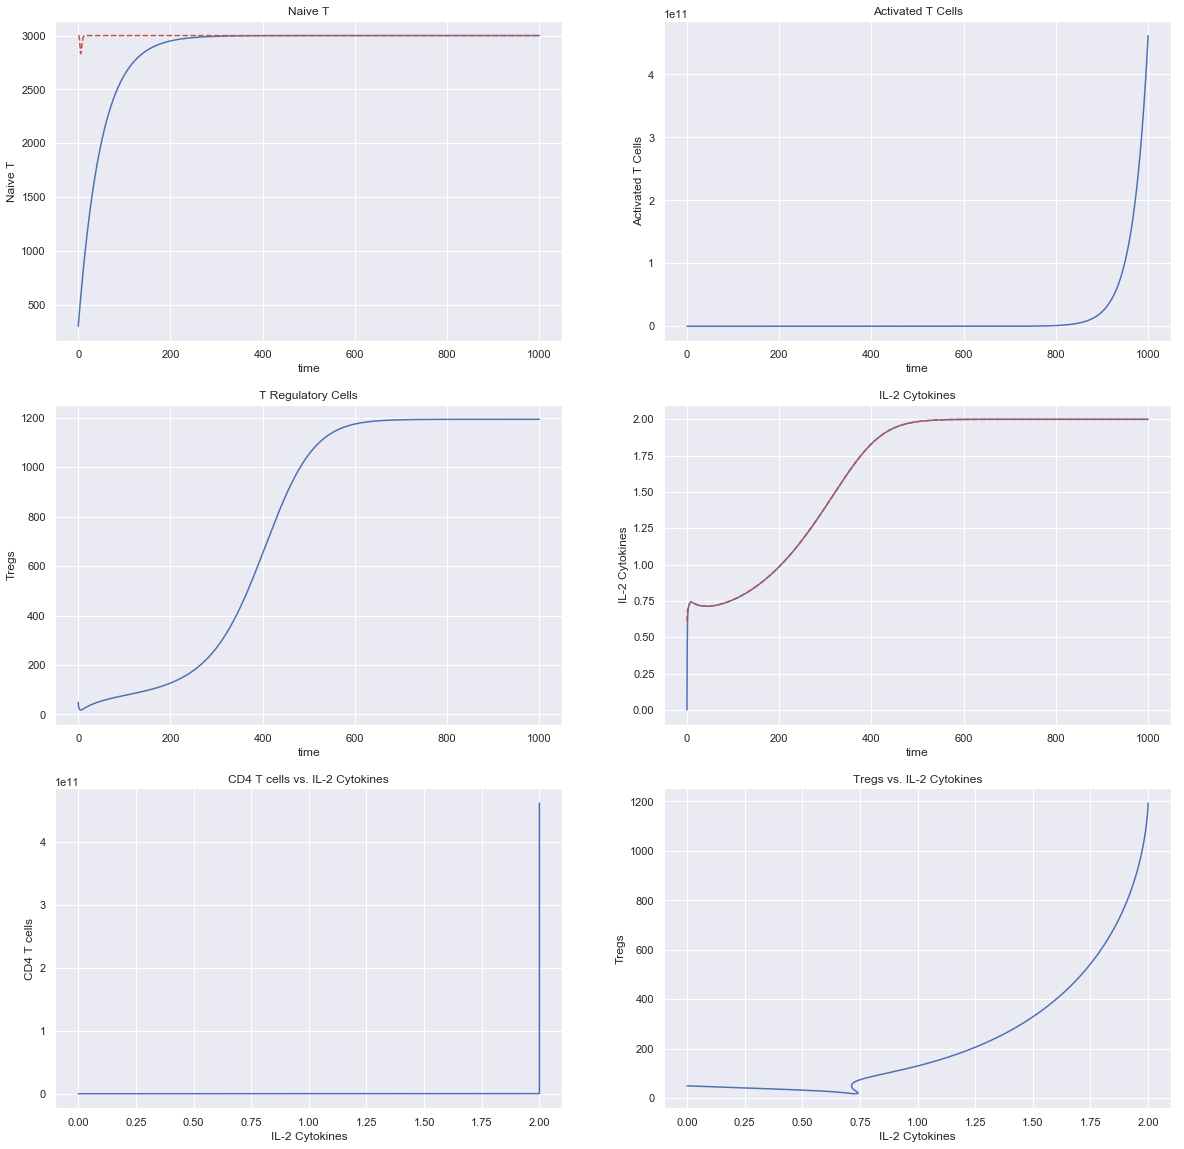

In [5]:
fig = PLT.figure(figsize=(20,20))
#Naive
ax1 = fig.add_subplot(321)
ax1.plot(Cells['time'],Cells['N'] , 'b-')
ax1.plot(Cells['time'], Cells['Nsteady'], 'r--')
ax1.set_xlabel('time')
ax1.set_ylabel('Naive T')
ax1.set_title('Naive T')
# T
ax2 = fig.add_subplot(322)
ax2.plot(Cells['time'],Cells['T'],'b-')
# ax2.plot(Cells['time'],Cells['Tsteady'],'r--')
ax2.set_xlabel('time')
ax2.set_ylabel('Activated T Cells')
ax2.set_title('Activated T Cells')
# Tregs
ax4 = fig.add_subplot(323)
ax4.plot(Cells['time'],Cells['R'],'b-')
# ax4.plot(Cells['time'],Cells['Rsteady'],'r--')
ax4.set_xlabel('time')
ax4.set_ylabel('Tregs')
ax4.set_title('T Regulatory Cells')
# IL-2
ax3 = fig.add_subplot(324)
ax3.plot(Cells['time'],Cells['I'],'b-')
ax3.plot(Cells['time'],Cells['Isteady'],'r--')
ax3.set_xlabel('time')
ax3.set_ylabel('IL-2 Cytokines')
ax3.set_title('IL-2 Cytokines')
# IL-2 vs T
ax5 = fig.add_subplot(325)
ax5.plot(Cells['I'],Cells['T'],'b-')
ax5.set_xlabel('IL-2 Cytokines')
ax5.set_ylabel('CD4 T cells')
ax5.set_title('CD4 T cells vs. IL-2 Cytokines')
# IL-2 vs. Tregs
ax6 = fig.add_subplot(326)
ax6.plot(Cells['I'],Cells['R'],'b-')
ax6.set_xlabel('IL-2 Cytokines')
ax6.set_ylabel('Tregs')
ax6.set_title('Tregs vs. IL-2 Cytokines')

PLT.show()

In [10]:
x = np.array([1,2,3,4])

In [32]:
x[:-1]

array([1, 2, 3])

In [31]:
f = (3 - x) * x + 1
f[1:] -= x[:-1]
f[:-1] -= 2 * x[1:]

NameError: name 'q' is not defined

In [22]:
f

array([-1, -4, -9, -6])

In [ ]:
# Guassian Model
# def model(t, coeffs):
#    return coeffs[0] + coeffs[1] * np.exp( - ((t-coeffs[2])/coeffs[3])**2 )

In [ ]:
# x0 are the parameters for the model
# residuals a function that calculates the differences between model and the data points
# waveform_1 - The data that you are going to fit
# t is time
# x = parameters optimized 

x, flag = leastsq(residuals, x0, args=(waveform_1, t))

In [8]:
f = 3

In [9]:
f[1:]

TypeError: 'int' object is not subscriptable